In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Models import TwoLevelSystems as TLS
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os
import yaml

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [3]:
omp = 1
mpi_k = 16
mpi_b = 1
mpi = int(mpi_k*mpi_b)
print('number of mpi',mpi)
sbatch_options = ['--partition=all12h'] #,'--ntasks-per-node=16']

number of mpi 16


In [4]:
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt')
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',scheduler='slurm',sbatch_options=sbatch_options)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'omp': 1,
 'mpi': 16,
 'mpi_run': 'mpirun -np',
 'executable': 'yambo_rt',
 'scheduler': 'slurm',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'sbatch_options': ['--partition=all12h'],
 'activate_BeeOND': True,
 'verbose': True}

We have performed some performance tests to find the optimal choice of the k_b parallelization.
Here the preliminary results

16_1 run is 1m-59s

16_2 run is 2m-36s

32_1 run is 4m-07s

32_1_2nodee does not create the BeeOND_Dir

# Echo signal from RT analysis in GaAs

This notebook contains the RT analysis of the photon echo mechanism for GaAs performed with Yambo.

## Analysis of the echo peak from the RT non-perturbative solution. Decay time determination and echo efficiency assessment 

We repeat the previous analysis using an improved k sampling in which an higher number of k points in the energy range of the pulses is used. 
In this way we test if a richer sampling reduce the non echo contribution due to an FID.

In this stage we also add an explicit decaying time on the coherences and use the echo signal to compute the decay time.

In [28]:
# Common parameters (eventually overwritten by the dictionary values)
time_step = 10 # as

# old analysis with a worst k-points sampling
#run_dir = 'RT_Echo_k100'
#source_dir = 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save'

# analysis with improved k-points sampling
run_dir = 'RT_Echo_k509-activated-energy_1.46-width_0.025'
source_dir = 'NSCF/bnds_8-kpoints_509-sampling_activated-energy_1.46-width_0.025.save'

We set the intensity of the pulses and time shift and we extract the echo signal from the non-perturbative solution

In [36]:
#int1, int2 = 1e3, 1e2 # intensity of the pulses in kW/cm^2
#int_str = 'int_1e3_1e2'

int1, int2 = 1e4, 2e3 # intensity of the pulses in kW/cm^2
int_str = 'int_1e4_2e3'

eta = 0.
eta_str = 'no_decay'

#eta = 4e-4
#eta_str = 'decay'

In [37]:
fwhm = 100 # fs FWHM of the pulses 
energy = 1.46 # 1.5 # eV energy of the pulsea
omega = energy/h_red # angular frequency of the pulse
period = h/energy # period of the pulse fs
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
NETime = 6000 # fs length of the simulation

In [38]:
np.exp(-eta*NETime)

1.0

In [39]:
#tau = {'0ps':0.,'0.5ps':period*177,'1ps':period*353,'1.5ps':period*530,'2ps':period*706,'2.5ps':period*883}
tau = {'0.5ps':period*177,'1ps':period*353,'1.5ps':period*530,'2ps':period*706,'2.5ps':period*883}
tau

{'0.5ps': 501.3788919123287,
 '1ps': 999.9251347178081,
 '1.5ps': 1501.3040266301368,
 '2ps': 1999.8502694356162,
 '2.5ps': 2501.2291613479447}

In [40]:
simulations = []
simulations.append({ # add the ref simulation
    'source_dir' : source_dir,
    'id' : ('ref',eta_str,int_str),
    'run_dir' : run_dir,
    'fields'  : [dict(index=1,int=int1,freq=energy,fwhm=fwhm,polarization='linear')],
    'sim_time'  : NETime,
    'eta'       : 1e-5,
    'no_sym'    : False,
    'bands'     : [2,5],
    'skip'      : True
    }
)
for t in tau: # add the simulations for each value of tau
    simulations.append({
        'id' : (t,'direct',eta_str,int_str),
        'source_dir' : source_dir,
        'run_dir' : run_dir,
        'fields'  : [dict(index=1,int=int1,freq=energy,fwhm=fwhm,polarization='linear'),
                     dict(index=2,int=int2,freq=energy,fwhm=fwhm,polarization='linear',tstart=tau[t],tstart_units='fs')],
        'sim_time'  : NETime,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'bands'     : [2,5],
        'skip'      : True
    })
    simulations.append({
        'id' : (t,'invert',eta_str,int_str),
        'source_dir' : source_dir,
        'run_dir' : run_dir,
        'fields'  : [dict(index=1,int=int1,freq=energy,fwhm=fwhm,polarization='linear'),
                     dict(index=2,int=int2,freq=energy,fwhm=fwhm,polarization='linear',
                     direction=[-1.,0.,0.],tstart=tau[t],tstart_units='fs')],
        'sim_time'  : NETime,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'bands'     : [2,5],
        'skip'      : True
    })

In [42]:
#simulations[1]

### Construction of the SAVE folder and FixSymm procedure

In [43]:
#for ind,sim in enumerate(simulations):
for sim in simulations:
    source_dir = sim['source_dir']
    run_dir = sim['run_dir']
    if not sim['no_sym']:
        sim['rt_run_dir'] = os.path.join(sim['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%str(sim['id']))
        U.build_SAVE(source_dir,run_dir,make_link=True,overwrite_if_found=False)
        U.make_FixSymm(run_dir,Efield1=[1.,0.,0.],overwrite_if_found=False)
    else:
        sim['rt_run_dir'] = sim['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim['id'])
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for sim in simulations:
    rt_run_dir = sim['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    #print(command)
    os.system(command)

build SAVE and perform FixSymm for ('ref', 'no_decay', 'int_1e4_2e3')
SAVE folder already present in RT_Echo_k509-activated-energy_1.46-width_0.025. No operations performed.
SAVE folder already present in RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for ('0.5ps', 'direct', 'no_decay', 'int_1e4_2e3')
SAVE folder already present in RT_Echo_k509-activated-energy_1.46-width_0.025. No operations performed.
SAVE folder already present in RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for ('0.5ps', 'invert', 'no_decay', 'int_1e4_2e3')
SAVE folder already present in RT_Echo_k509-activated-energy_1.46-width_0.025. No operations performed.
SAVE folder already present in RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for ('1ps', 'direct', 'no_decay', 'int_1e4_2e3')
SAVE folder already present in R

### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [44]:
io_time = [50.0,50.0,1.0] # [5.0,1.0,1.0] # I/O (CARRIERs - GF - OUTPUT) in fs
io_cacheTime = [[50.0,100.0],'fs'] # Time between two consecutive (caching - I/O) of OBSERVABLES

In [45]:
for sim in simulations:
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=sim['rt_run_dir'])
    for f in sim['fields']:
        rt_input.set_rt_field(**f)
    if eta == 0.:
        rt_input.set_rt_bands(bands=sim['bands'],scissor=scissor,damping_valence=sim['eta'],damping_conduction=sim['eta'])
    else:
        rt_input.set_rt_bands(bands=sim['bands'],scissor=scissor,damping_valence=0.,damping_conduction=0.)
        rt_input['variables']['PhLifeTime'] = [1/eta,'fs']
    rt_input.set_rt_simulationTimes(sim_time=sim['sim_time'],io_time=io_time,time_step=time_step)
    rt_input.set_rt_cpu(k=mpi_k,b=mpi_b)
    rt_input['variables']['DBsIOoff']='obs carriers'  # do not write these databases on file
    rt_input['variables']['IOCachetime'] = io_cacheTime
    #rt_input['arguments'].append('SaveGhistory')
    sim['input'] = rt_input

In [46]:
#simulations[1]

In [47]:
study = D.Dataset(num_tasks=3)
study.set_postprocessing_function(D.PostProcessing.yambo_parse_data)

Initialize a Dataset with 3 parallel tasks


In [48]:
for sim in simulations:
    study.append_run(id=sim['id'],input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])

In [49]:
study.ids

[('ref', 'no_decay', 'int_1e4_2e3'),
 ('0.5ps', 'direct', 'no_decay', 'int_1e4_2e3'),
 ('0.5ps', 'invert', 'no_decay', 'int_1e4_2e3'),
 ('1ps', 'direct', 'no_decay', 'int_1e4_2e3'),
 ('1ps', 'invert', 'no_decay', 'int_1e4_2e3'),
 ('1.5ps', 'direct', 'no_decay', 'int_1e4_2e3'),
 ('1.5ps', 'invert', 'no_decay', 'int_1e4_2e3'),
 ('2ps', 'direct', 'no_decay', 'int_1e4_2e3'),
 ('2ps', 'invert', 'no_decay', 'int_1e4_2e3'),
 ('2.5ps', 'direct', 'no_decay', 'int_1e4_2e3'),
 ('2.5ps', 'invert', 'no_decay', 'int_1e4_2e3')]

In [ ]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] with the parallel task_groups [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10]] 

Run the task [0, 1, 2] 
run command: mpirun -np 16 yambo_rt -F 0.5ps-direct-no_decay-int_1e4_2e3.in -J 0.5ps-direct-no_decay-int_1e4_2e3 -C 0.5ps-direct-no_decay-int_1e4_2e3
slurm submit:  cd RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm ; sbatch job_0.5ps-direct-no_decay-int_1e4_2e3.sh
computation 0.5ps-direct-no_decay-int_1e4_2e3 is running...
run command: mpirun -np 16 yambo_rt -F 0.5ps-invert-no_decay-int_1e4_2e3.in -J 0.5ps-invert-no_decay-int_1e4_2e3 -C 0.5ps-invert-no_decay-int_1e4_2e3run command: mpirun -np 16 yambo_rt -F ref-no_decay-int_1e4_2e3.in -J ref-no_decay-int_1e4_2e3 -C ref-no_decay-int_1e4_2e3

slurm submit: slurm submit:   cd RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm ; sbatch job_0.5ps-invert-no_decay-int_1e4_2e3.shcd RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm ; sbatch job_ref-no_decay-int_1e4_2e3.sh

compu

0.0475196963
0.0528137721
0.0512265858
0.0513218428
0.0527413043
0.0515418093
0.0525360312
0.0517689196
0.0523119671
0.0517634371
0.052316026


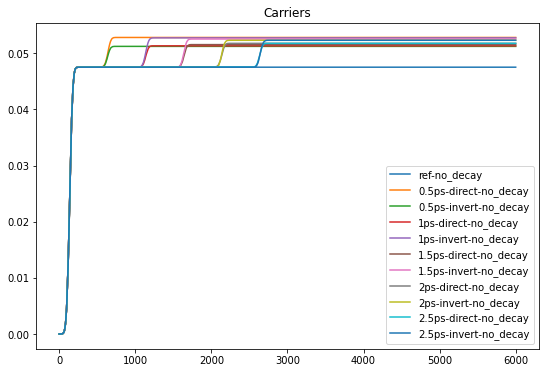

In [148]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    print(dne[-1])
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Carriers')
    plt.legend()

In [ ]:
for ind,r in results.items():
    plt.figure(figsize=(10,6))
    t = r.data['external_field']['time']
    profile = r.data['external_field']['Profile']
    plt.plot(t,profile,label=D.name_from_id(study.ids[ind]))
    plt.title('Field profile')
    plt.legend()

In [ ]:
for ind,r in results.items():
    plt.figure(figsize=(10,6))
    t = r.data['polarization']['time']
    dne = r.data['polarization']['Pol_x']
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Polarization x component')
    plt.legend()

### Observables from the density matrix

We check that the observables reported in output files can be obtained from the density matrix

In [78]:
study.ids

[('ref', 'decay'),
 ('0.5ps', 'direct', 'decay'),
 ('0.5ps', 'invert', 'decay'),
 ('1ps', 'direct', 'decay'),
 ('1ps', 'invert', 'decay'),
 ('2ps', 'direct', 'decay'),
 ('2ps', 'invert', 'decay'),
 ('2.5ps', 'direct', 'decay'),
 ('2.5ps', 'invert', 'decay')]

In [139]:
sim = 0

In [140]:
green = results[sim].RTGreen
dm0 = green.buildEqDensityMatrix(num_occupied_bands=3)
dm = green.buildDensityMatrix(equilibrium_dm=dm0)
ntimes = len(dm) # dimension of the time index
nk = len(dm[0]) # dimension of the k index
dm.shape

(2401, 6094, 4, 4)

We define a time variable that convert the time index of the density matrix in
the effective simulation time

In [141]:
time_dm = np.linspace(0,NETime,ntimes)
time_dm.shape

(2401,)

In [142]:
time_dm

array([0.0000e+00, 2.5000e+00, 5.0000e+00, ..., 5.9950e+03, 5.9975e+03,
       6.0000e+03])

From the dm we can compute the number of carriers in function of time

In [143]:
trace_cc = np.trace(dm[:,:,3:,3:],axis1=2,axis2=3) #trace in the conduction sector
carriers = np.mean(trace_cc,axis=1) # average over k

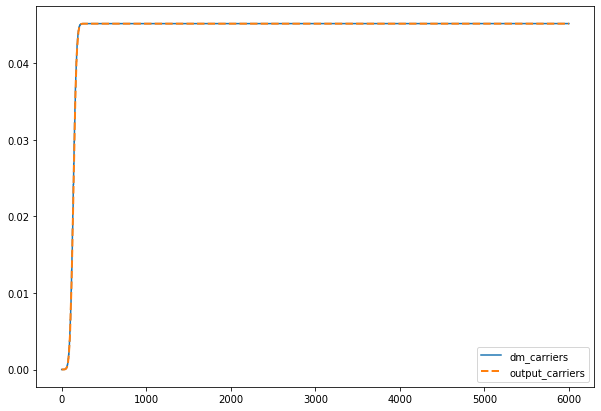

In [144]:
plt.figure(figsize=(10,7))
plt.plot(time_dm,carriers.real,label='dm_carriers')
t = results[sim].data['carriers']['time']
dne = results[sim].data['carriers']['dne']
plt.plot(t,dne,label='output_carriers',linestyle='--',linewidth=2)
plt.legend()

We can compute also the expectation value of the polarization and compare it with the one
provided in the output files (it has to be rescaled with the lattice volume).

In [ ]:
x_dipole = results[sim].dipoles.r_dipole(0)

In [146]:
dft = results[sim].dft
lat_vol = dft.eval_lattice_volume()
lat_vol

294.0614899039999

In [147]:
Polx = -np.mean(np.trace(np.matmul(dm,x_dipole),axis1=2,axis2=3),axis=1)
Polx = Polx.real/lat_vol

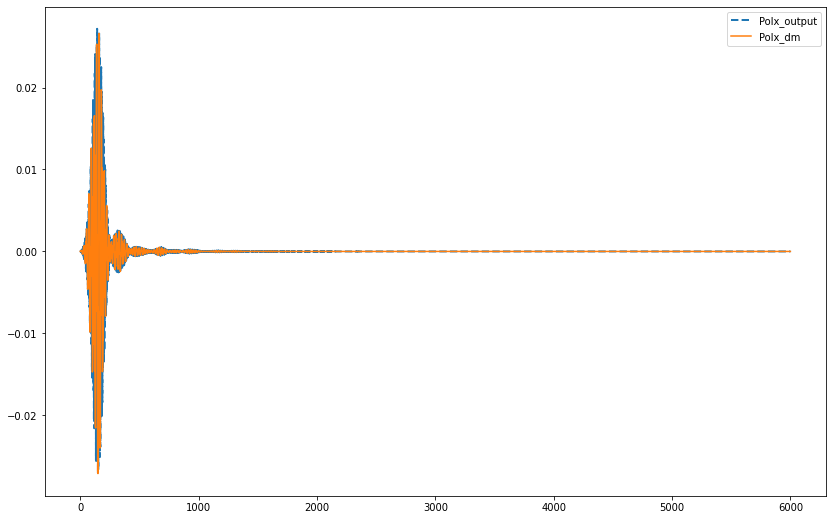

In [148]:
plt.figure(figsize=(14,9))
t = results[sim].data['polarization']['time']
Polx_out = results[sim].data['polarization']['Pol_x']
plt.plot(t,Polx_out,label='Polx_output',linestyle='--',linewidth=2)
plt.plot(time_dm,Polx.real,label='Polx_dm')
#plt.xlim(500,1000)
plt.legend()

### Extraction of the echo signal

In [149]:
x_dipole = results[0].dipoles.r_dipole(0)

In [154]:
dft = results[0].dft
lat_vol = dft.eval_lattice_volume()
lat_vol

294.0614899039999

In [155]:
ind_ref = study.ids.index(('ref',eta_str))
green_ref = results[ind_ref].RTGreen
dm0_ref = green_ref.buildEqDensityMatrix(num_occupied_bands=3)
dm_ref = green_ref.buildDensityMatrix(equilibrium_dm=dm0_ref)
ntimes = len(dm_ref) # dimension of the time index
time_dm = np.linspace(0,NETime,ntimes)

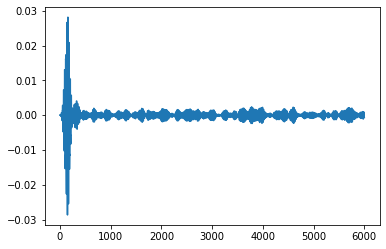

In [156]:
Polx_ref = -np.mean(np.trace(np.matmul(dm_ref,x_dipole),axis1=2,axis2=3),axis=1)                              
Polx_ref = Polx_ref.real/lat_vol
plt.plot(time_dm,Polx_ref)

In [157]:
echo = {}

In [158]:
for t in tau:
    if t not in echo:
        print('add tau %s to echo'%t)
        dm =  []
        for val in ['direct','invert']:
            ind = study.ids.index((t,val,eta_str))
            #print(t,val,'index',ind)
            green = results[ind].RTGreen
            dm0 = green.buildEqDensityMatrix(num_occupied_bands=3)
            dm.append(green.buildDensityMatrix(equilibrium_dm=dm0))
        dm_echo = 0.5*(dm[0]+dm[1])-dm_ref
        Polx_echo = -np.mean(np.trace(np.matmul(dm_echo,x_dipole),axis1=2,axis2=3),axis=1)                              
        echo[t] = Polx_echo.real/lat_vol    

add tau 0.5ps to echo
add tau 1ps to echo
add tau 1.5ps to echo
add tau 2ps to echo
add tau 2.5ps to echo


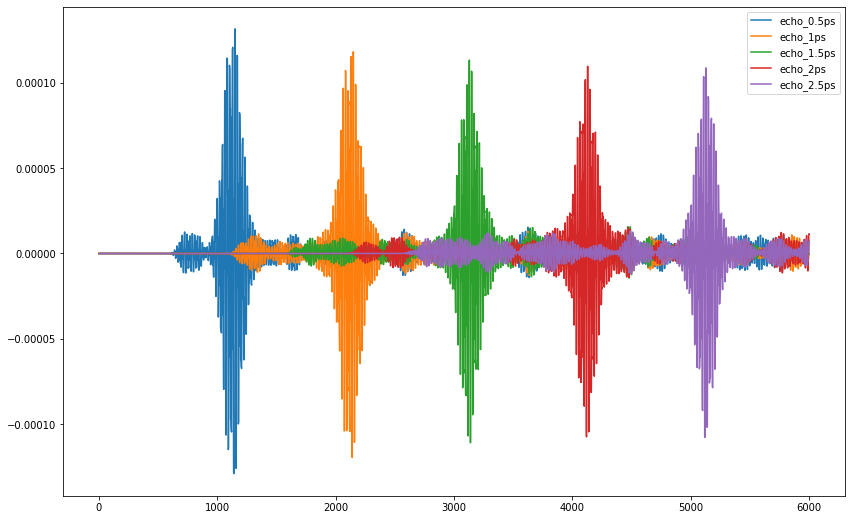

In [159]:
plt.figure(figsize=(14,9))
for t in echo:
    plt.plot(time_dm,echo[t],label='echo_'+t)
plt.legend()

echo from the observable polarization

In [186]:
px_obs_ref = results[0].data['polarization']['Pol_x']
#px_obs_ref = results[0].data['current']['col1']
time_obs = results[0].data['polarization']['time']

In [187]:
echo_obs = {}

In [188]:
for t in tau:
    px_obs =  []
    for val in ['direct','invert']:
        ind = study.ids.index((t,val,eta_str))
        px_obs.append(results[ind].data['polarization']['Pol_x'])
        #px_obs.append(results[ind].data['current']['col1'])
    echo_obs[t] = 0.5*(px_obs[0]+px_obs[1])-px_obs_ref

In [190]:
# correct the eta factor of the valence and conduction bands
nu = 2*1e-5/h
nu

4.835978485250137e-06

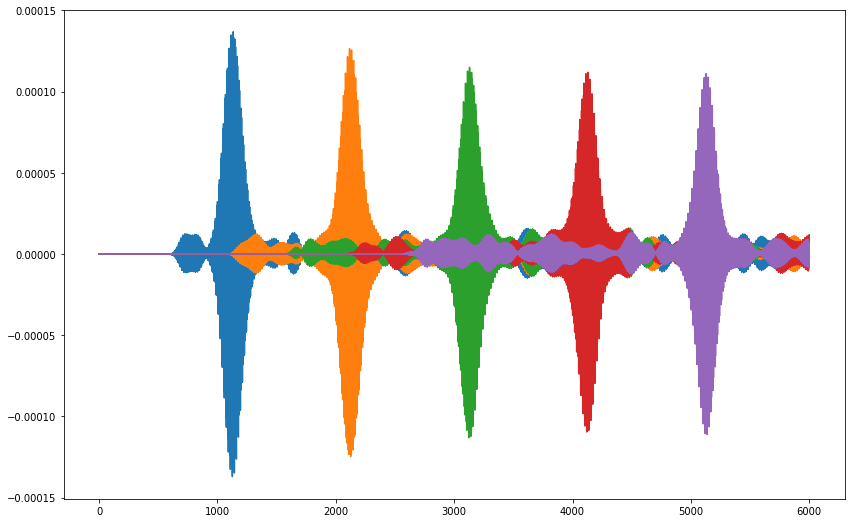

In [193]:
plt.figure(figsize=(14,9))
for t in tau:
    plt.plot(time_obs,echo_obs[t]*np.exp(nu*time_obs))
    #plt.plot(time_dm,echo[t],label='echo_'+t)
#plt.xlim(4000,4200)

We save relevant data on file

In [113]:
out = {}
out['time'] = time_dm.tolist()
t = results[0].data['external_field']['time']
out['time_output'] = t.tolist()
out['ref'] = Polx_ref.tolist()
out['echo'] = {}
out['profile'] = {}
for tau,val in echo.items():
    out['echo'][tau] = val.tolist()
    ind = study.ids.index((tau,'direct',eta_str))
    profile = results[ind].data['external_field']['Profile']
    out['profile'][tau] = profile.tolist()

In [115]:
file = 'Results/echo_%s.yaml'%eta_str
print('save on file %s'%file)
with open(file, 'w') as f:
    yaml.dump(out,f,default_flow_style=False)

save on file Results/echo_decay.yaml


And we can read data from file

In [94]:
file = 'Results/echo_%s.yaml'%eta_str
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'ref', 'time'])

In [95]:
time_dm = data_loaded['time']
time_output = data_loaded['time_output']
ref = data_loaded['ref']
echo = data_loaded['echo']
profile = data_loaded['profile']

In [97]:
profile.keys()

dict_keys(['0.5ps', '1.5ps', '1ps', '2.5ps', '2ps', 'time'])

In [116]:
from copy import deepcopy

In [117]:
out_bkp = deepcopy(out)

In [119]:
out_bkp.keys()

dict_keys(['time', 'time_output', 'ref', 'echo', 'profile'])

In [129]:
file = 'Results/echo_decay.yaml'
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'ref', 'time', 'time_output'])

In [128]:
data_loaded.keys()

dict_keys(['echo', 'profile', 'ref', 'time', 'time_output'])

In [124]:
data_loaded['time_output'] = out_bkp['time_output']
data_loaded['profile'] = out_bkp['profile']

In [125]:
data_loaded.keys()

dict_keys(['echo', 'ref', 'time', 'time_output', 'profile'])

In [126]:
file = 'Results/echo_no_decay.yaml'
print('save on file %s'%file)
with open(file, 'w') as f:
    yaml.dump(data_loaded,f,default_flow_style=False)

save on file Results/echo_no_decay.yaml
